In [12]:
import ants
import nibabel as nb
import os
import shutil
import sys
import glob
import numpy as np
from subprocess import Popen, DEVNULL, STDOUT, check_call
sys.path.append('/home/mathilde/Documents/scripts/meld_fe_io')
from scripts.coregistration import ants_coregister_to_fixed, ants_coregister_with_transform

In [5]:
BIDS_dir = '/home/mathilde/Documents/projects/MELD_fe/230510_develop_coregister/input'
ref_file_stripped = '../data/template/mni_icbm152_t1_tal_nlin_sym_09a_brain.nii'
output_dir = '/home/mathilde/Documents/projects/MELD_fe/230510_develop_coregister/output'

subjects = os.listdir(BIDS_dir)
print(subjects)


['sub-MELDH4P0009', 'sub-MELDH4P0220', 'sub-MELDH4P0018', 'sub-MELDH4P0016', 'sub-MELDH4P0004', 'sub-MELDH4P0007', 'sub-MELDH4P0011', 'sub-MELDH4P0015', 'sub-MELDH4P0005', 'sub-MELDH4P0020', 'sub-MELDH4P0017', 'sub-MELDH4P0013', 'sub-MELDH4P0001', 'sub-MELDH4P0014', 'sub-MELDH4P0019', 'sub-MELDH4P0003', 'sub-MELDH4P0002', 'sub-MELDH4P0012', 'sub-MELDH4P0008', 'sub-MELDH4P0006', 'sub-MELDH4P0010']


In [7]:


for subject in subjects:

    print(subject)

    #get T1 and lesion mask if exists
    T1_file = glob.glob(os.path.join(BIDS_dir,subject, 'anat','*_preop_T1w.nii.gz'))[0]
    try:
        lesion_mask_file = glob.glob(os.path.join(BIDS_dir,subject, 'anat','*_lesion_mask.nii.gz'))[0]
    except:
        lesion_mask_file = None
        print(f'no lesion mask for subject {subject}')
    
    if lesion_mask_file != None:

        # create folder output subject
        output_dir_sub = os.path.join(output_dir,subject)
        os.makedirs(output_dir_sub, exist_ok=True)

        # skull strip T1 
        T1_skullstripp = os.path.join(output_dir_sub,f'{subject}_T1brain.nii.gz')
        command = format(f"bet {T1_file} {T1_skullstripp}")
        proc = Popen(command, shell=True,)
        proc.wait()

        # Coregister T1 skullstripped to MNI space and save transform
        output_file = os.path.join(output_dir_sub, f'{subject}_T1brain_in_MNI.nii.gz')
        transform_file_base = os.path.join(output_dir_sub,f'{subject}_transform_to_MNI')
        ants_coregister_to_fixed(T1_skullstripp, ref_file_stripped, output_file, save_transform=transform_file_base, transform_type = 'SyN')

        # Coregister T1 using transform
        output_file = os.path.join(output_dir_sub, f'{subject}_T1_in_MNI.nii.gz')
        ants_coregister_with_transform(T1_file, ref_file_stripped, output_file, transform_file_base)

        # Coregister lesion mask using transform
        output_file = os.path.join(output_dir_sub, f'{subject}_lesionmask_in_MNI.nii.gz')
        ants_coregister_with_transform(lesion_mask_file, ref_file_stripped, output_file, transform_file_base)









sub-MELDH4P0009
sub-MELDH4P0220
sub-MELDH4P0018
sub-MELDH4P0016
sub-MELDH4P0004
no lesion mask for subject sub-MELDH4P0004
sub-MELDH4P0007
sub-MELDH4P0011
sub-MELDH4P0015
no lesion mask for subject sub-MELDH4P0015
sub-MELDH4P0005
no lesion mask for subject sub-MELDH4P0005
sub-MELDH4P0020
sub-MELDH4P0017
no lesion mask for subject sub-MELDH4P0017
sub-MELDH4P0013
sub-MELDH4P0001
no lesion mask for subject sub-MELDH4P0001
sub-MELDH4P0014
sub-MELDH4P0019
sub-MELDH4P0003
no lesion mask for subject sub-MELDH4P0003
sub-MELDH4P0002
sub-MELDH4P0012
no lesion mask for subject sub-MELDH4P0012
sub-MELDH4P0008
sub-MELDH4P0006
sub-MELDH4P0010
no lesion mask for subject sub-MELDH4P0010


In [9]:
# load lesion masks
data=[]
for subject in subjects:
    output_dir_sub = os.path.join(output_dir,subject)
    lesion_mask_MNI= os.path.join(output_dir_sub, f'{subject}_lesionmask_in_MNI.nii.gz')

    try:  
        data.append(nb.load(lesion_mask_MNI).get_fdata())
    except:
        pass


In [20]:
#sum lesion mask and save nifti
sum_lesion_file =  os.path.join(BIDS_dir,'sum_lesion_mask.nii.gz')

#sum lesion mask
data=np.array(data)
data_sum = data.sum(axis=0)
data_sum.shape

#save as nifti
template = nb.load(ref_file_stripped)
new_img = nb.Nifti1Image(data_sum, template.affine, template.header)
nb.save(new_img, sum_lesion_file)




Text(0.5, 1.0, 'Location of lesion ')

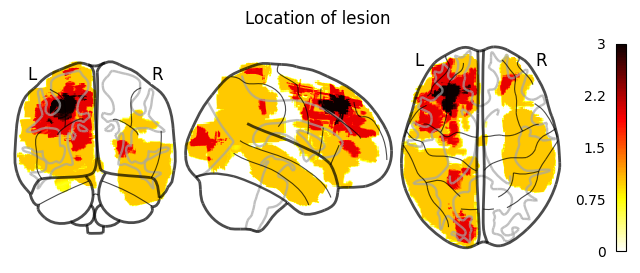

In [35]:
# plot lesion mask
from nilearn import plotting
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(8,3))

plotting.plot_glass_brain(sum_lesion_file, colorbar=True, axes=ax)
ax.set_title('Location of lesion ')

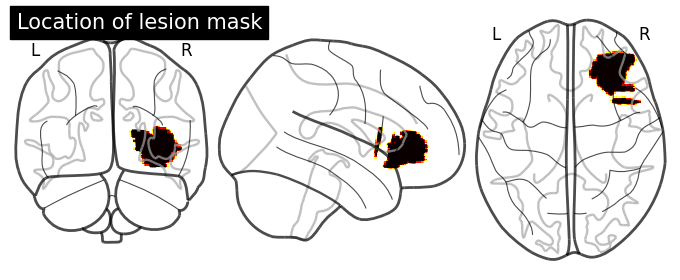

In [27]:
# plot only one 
file = '/home/mathilde/Documents/projects/MELD_fe/230510_develop_coregister/output/sub-MELDH4P0013/sub-MELDH4P0013_lesionmask_in_MNI.nii.gz'
plotting.plot_glass_brain(file, title='Location of lesion mask')